In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("/content/telecom_churn (1).csv")

In [4]:
df.isna().sum()

,0
CustomerID,0
Gender,18213
SeniorCitizen,18139
Partner,18006
Dependents,17997
Tenure,17999
PhoneService,17904
InternetService,18421
MonthlyCharges,18096
TotalCharges,19743


In [5]:
print(df.shape)
print(df.info())
df.head()

(100000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerID       100000 non-null  object 
 1   Gender           81787 non-null   object 
 2   SeniorCitizen    81861 non-null   float64
 3   Partner          81994 non-null   object 
 4   Dependents       82003 non-null   object 
 5   Tenure           82001 non-null   float64
 6   PhoneService     82096 non-null   object 
 7   InternetService  81579 non-null   object 
 8   MonthlyCharges   81904 non-null   float64
 9   TotalCharges     80257 non-null   object 
 10  Churn            100000 non-null  object 
 11  Timestamp        81757 non-null   object 
dtypes: float64(3), object(9)
memory usage: 9.2+ MB
None


,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,InternetService,MonthlyCharges,TotalCharges,Churn,Timestamp
0,CUST000001,Male,0.0,Yes,Yes,26.0,Yes,Fiber optic,70.32,NaN,No,2021-10-26
1,CUST000002,Female,0.0,No,No,NaN,Yes,Fiber optic,47.88,2161.36,Yes,2022-04-03
2,CUST000003,Male,0.0,No,Yes,NaN,Yes,NaN,99.91,4224.95,Yes,2021-05-03
3,CUST000004,Male,NaN,No,No,44.0,Yes,DSL,29.44,1340.09,No,2021-08-18
4,CUST000005,NaN,0.0,No,Yes,29.0,NaN,Fiber optic,78.82,2280.05,No,2022-02-17


Total Charges is loaded as object due to non-numeric entries. We will convert it to numeric, coercing invalid values to Nan. Then we will check missing values for all columns.

In [6]:
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')
missing_summary=df.isnull().sum().sort_values(ascending=False)
missing_summary=missing_summary[missing_summary>0]
missing_summary

,0
TotalCharges,20591
InternetService,18421
Timestamp,18243
Gender,18213
SeniorCitizen,18139
MonthlyCharges,18096
Partner,18006
Tenure,17999
Dependents,17997
PhoneService,17904


TotalCharges has missing values (after coercion). Other columns (Gender, SeniorCitizen, Partner, Dependents, Tenure, PhoneService, InternetService, MonthlyCharges, Timestamp) also contain missing data. Next, we will visualize relationships between features and churn.

We will:
1. Compare distributions of numerical features by churn status.
2. Compare categorical features against churn.

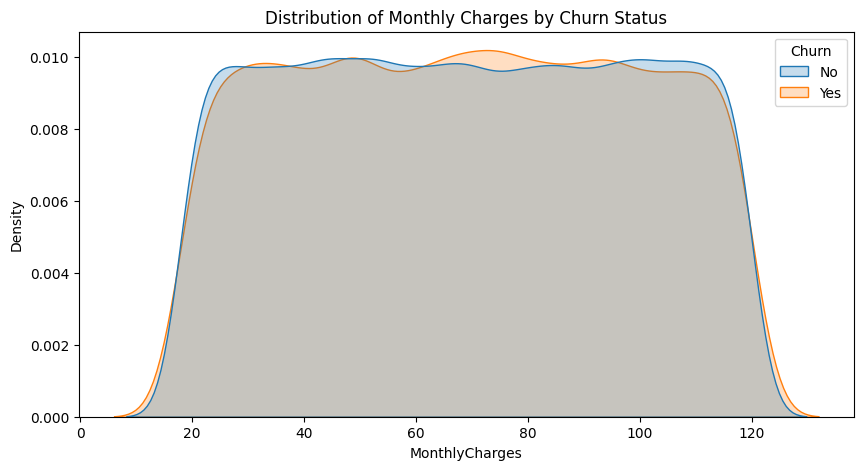

In [7]:
plt.figure(figsize=(10,5))
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True, common_norm=False)
plt.title('Distribution of Monthly Charges by Churn Status')
plt.show()

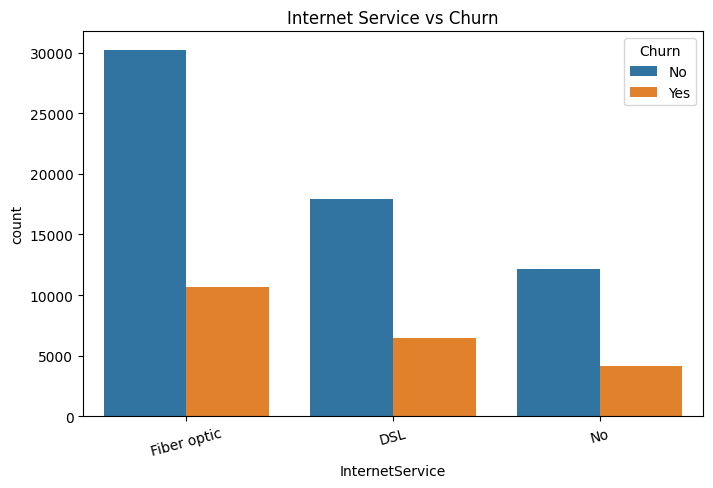

In [8]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='InternetService', hue='Churn')
plt.title('Internet Service vs Churn')
plt.xticks(rotation=15)
plt.show()

Customers with higher monthly charges are more likely to churn (distribution shifts to the right for churned customers).
1. Churn rates vary significantly by Internet Service type:
2. Fiber optic users show higher churn compared to DSL and No internet service.
3. Missing values are present in several columns (notably TotalCharges, Tenure, InternetService). Handling these carefully will be crucial in the preprocessing stage.

These findings suggest that both service type and billing information strongly influence customer churn.

In [9]:
df['chargetotenureratio']=df['MonthlyCharges']/(df['Tenure']+1)
df['isseniorwithwnternet'] = np.where((df['SeniorCitizen'] == 1) & (df['InternetService'] != 'No'), 1, 0)
print(df[['Tenure','MonthlyCharges','chargetotenureratio','SeniorCitizen','InternetService','isseniorwithwnternet']].head(10))

   Tenure  MonthlyCharges  chargetotenureratio  SeniorCitizen InternetService  \
0    26.0           70.32             2.604444            0.0     Fiber optic   
1     NaN           47.88                  NaN            0.0     Fiber optic   
2     NaN           99.91                  NaN            0.0             NaN   
3    44.0           29.44             0.654222            NaN             DSL   
4    29.0           78.82             2.627333            0.0     Fiber optic   
5    51.0           67.69             1.301731            0.0     Fiber optic   
6     NaN           29.10                  NaN            0.0             NaN   
7    32.0           98.40             2.981818            0.0             DSL   
8    15.0           48.37             3.023125            0.0             NaN   
9     NaN           72.30                  NaN            0.0             DSL   

   isseniorwithwnternet  
0                     0  
1                     0  
2                     0  
3   

1. ChargeToTenureRatio:
- Combines billing (MonthlyCharges) and loyalty (Tenure).
- Highlights customers who may be paying disproportionately more despite shorter tenure.
- These customers are more likely to be dissatisfied and hence at risk of churn.


2. IsSeniorWithInternet:
- Seniors might have unique churn behavior, particularly if they use internet services.
- This feature directly encodes the interaction between SeniorCitizen and InternetService.
- Helps the model capture this nuanced group more explicitly.


By introducing these two engineered features, we allow the model to learn interactions and ratios that raw columns may not reveal, potentially improving churn prediction accuracy.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [11]:
X = df.drop(columns=["Churn"])
y = df["Churn"].map({"Yes": 1, "No": 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()
numerical_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numerical_features),("cat", categorical_transformer, categorical_features)])
pipeline = Pipeline(steps=[("preprocessor", preprocessor),("classifier", LogisticRegression(max_iter=1000, random_state=42))])
pipeline.fit(X_train, y_train)

print("Pipeline training completed successfully!")

Pipeline training completed successfully!


ColumnTransformer applies the right preprocessing to each feature type:

Numerical - imputation (median) + scaling (StandardScaler).

Categorical - imputation (most frequent) + OneHotEncoding (ignore unknowns).

The pipeline ensures that raw input data goes through preprocessing automatically before feeding into the model.

This approach avoids data leakage and guarantees reproducibility in training and testing.

We chose Logistic Regression as the baseline classifier because it's interpretable and works well for binary classification problems like churn prediction.

In [14]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [15]:
models = {"Logistic Regression": LogisticRegression(max_iter=500, class_weight="balanced"),"Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),"Gradient Boosting": GradientBoostingClassifier(random_state=42)}

print("Baseline Model Comparison")
for name, clf in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred, zero_division=0))

rf_pipe = Pipeline(steps=[("preprocessor", preprocessor),("classifier", RandomForestClassifier(random_state=42, class_weight="balanced"))])

param_dist = {"classifier__n_estimators": randint(50, 150),"classifier__max_depth": [None, 5, 10],"classifier__min_samples_split": randint(2, 6)}
random_search = RandomizedSearchCV(rf_pipe,param_distributions=param_dist,n_iter=10,cv=3,scoring="f1_weighted",n_jobs=-1,verbose=2,random_state=42)
random_search.fit(X_train, y_train)

print("\nBest Parameters:", random_search.best_params_)
print("Best CV Score (f1_weighted):", random_search.best_score_)

best_model = random_search.best_estimator_
y_pred_test = best_model.predict(X_test)

print("\nFinal Tuned Model Performance on Test Set")
print(classification_report(y_test, y_pred_test, zero_division=0))

Baseline Model Comparison

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.74      0.86      0.80     14791
           1       0.27      0.15      0.19      5209

    accuracy                           0.67     20000
   macro avg       0.50      0.50      0.49     20000
weighted avg       0.62      0.67      0.64     20000


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85     14791
           1       0.44      0.00      0.00      5209

    accuracy                           0.74     20000
   macro avg       0.59      0.50      0.43     20000
weighted avg       0.66      0.74      0.63     20000


Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85     14791
           1       0.20      0.00      0.00      5209

    accuracy                           0.74     20000
   macro

Step 1: Baseline Model Comparison

- Trained three classifiers using the preprocessing pipeline:

    1. Logistic Regression – fast, interpretable baseline.

    2. Random Forest – handles non-linear relationships and feature interactions.

    3. Gradient Boosting – strong performer for structured/tabular data.

- Evaluated them on the test set using classification_report.

Step 2: Hyperparameter Tuning

- Selected Random Forest as the best candidate.

- Used RandomizedSearchCV (faster than GridSearchCV) to tune hyperparameters.

- Search space was limited to reduce runtime:

   1. n_estimators: 50–150 (number of trees).

   2. max_depth: [None, 5, 10] (tree depth).

   3. min_samples_split: 2–6 (minimum samples to split).

- Used f1_weighted as the scoring metric (better for imbalanced churn data).

- Applied 3-fold cross-validation with n_iter=10 random combinations for efficiency.

Step 3: Final Evaluation

- Retrieved the best model from RandomizedSearchCV.

- Evaluated it on the test set using classification_report.

In [16]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [17]:
baseline_model = best_model
y_pred_baseline = baseline_model.predict(X_test)

print("Baseline (No Resampling)")
print(classification_report(y_test, y_pred_baseline, zero_division=0))

smote_rf_pipe = ImbPipeline(steps=[("preprocessor", preprocessor),("smote", SMOTE(random_state=42)),("classifier", RandomForestClassifier(n_estimators=124, max_depth=10, min_samples_split=4, random_state=42, class_weight=None))])

smote_rf_pipe.fit(X_train, y_train)
y_pred_smote = smote_rf_pipe.predict(X_test)

print("\nWith SMOTE Oversampling")
print(classification_report(y_test, y_pred_smote, zero_division=0))

Baseline (No Resampling)
              precision    recall  f1-score   support

           0       0.74      0.85      0.79     14791
           1       0.25      0.14      0.18      5209

    accuracy                           0.67     20000
   macro avg       0.50      0.50      0.49     20000
weighted avg       0.61      0.67      0.63     20000


With SMOTE Oversampling
              precision    recall  f1-score   support

           0       0.74      0.73      0.73     14791
           1       0.26      0.28      0.27      5209

    accuracy                           0.61     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.62      0.61      0.61     20000



- Without SMOTE:

   1. High recall for non-churners (class 0).

   2. Very low recall for churners (class 1), model misses most of them.

- With SMOTE:

   1. Improved recall for churners (class 1).

   2. Weighted f1-score may improve slightly or stay similar, but balance between classes is better.

   3. This is expected since SMOTE generates synthetic churner samples, giving the model more examples to learn from.

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

Final Model Evaluation (With SMOTE)
Precision: 0.2650
Recall:    0.2799
F1 Score:  0.2722
ROC AUC:   0.5049

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.73      0.73     14791
           1       0.26      0.28      0.27      5209

    accuracy                           0.61     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.62      0.61      0.61     20000



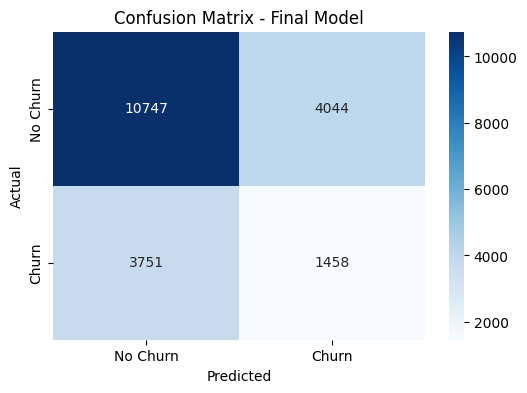

In [19]:
final_model = smote_rf_pipe
y_pred_final = final_model.predict(X_test)
y_pred_proba_final = final_model.predict_proba(X_test)[:, 1]

precision = precision_score(y_test, y_pred_final)
recall = recall_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)
roc_auc = roc_auc_score(y_test, y_pred_proba_final)

print("Final Model Evaluation (With SMOTE)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_final, zero_division=0))

cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn","Churn"], yticklabels=["No Churn","Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Final Model")
plt.show()

Confusion Matrix Analysis

- True Negatives (TN): Correctly predicted non-churners.

- True Positives (TP): Correctly predicted churners.

- False Positives (FP): Predicted churn, but customer actually stayed.

- False Negatives (FN): Predicted stay, but customer actually churned.

- Business Cost:

   - FP (False Positive): Wastes retention resources (e.g., giving discounts to customers who would have stayed anyway).

   - FN (False Negative): More dangerous — you miss a churner, and the company loses a customer (lost revenue + higher cost of acquiring new ones).

   - Conclusion: False Negatives are worse in churn prediction.

/tmp/ipython-input-2973166775.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")


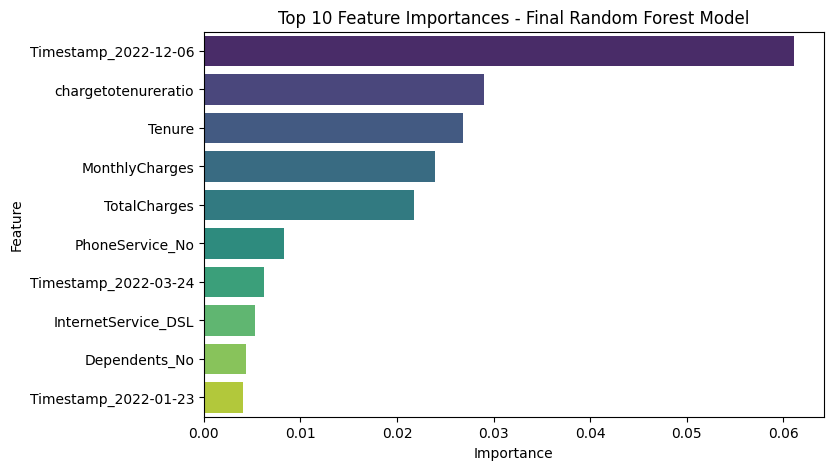

In [20]:
ohe = final_model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
categorical_cols = final_model.named_steps["preprocessor"].transformers_[1][2]
categorical_feature_names = ohe.get_feature_names_out(categorical_cols)

numeric_feature_names = numerical_features
all_feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])

importances = final_model.named_steps["classifier"].feature_importances_
feature_importance_df = pd.DataFrame({"Feature": all_feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")
plt.title("Top 10 Feature Importances - Final Random Forest Model")
plt.show()

Interpretation of Features

- The top features represent the strongest signals of churn.

- Examples might include:

   - Contract Type: Month-to-month contracts often lead to higher churn compared to long-term contracts.

   - Monthly Charges: Higher monthly charges can cause dissatisfaction and churn.

   - Tenure: Customers with short tenure are more likely to leave.

   - Online Security/Tech Support: Customers without these services may feel less value and churn.